### Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Basketball analysis

### Load DataFrame check for NAN values (drop NAN rows)

In [2]:
df = pd.read_csv("basketball_scores.csv", index_col=0)
df.head()

,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p
0,NBA,2017/2018,85.0,108.0,0.0,0.0,2.43,1.61
1,NBA,2017/2018,102.0,110.0,0.0,0.0,2.28,1.68
2,NBA,2017/2018,122.0,103.0,1.0,0.0,1.18,5.36
3,NBA,2017/2018,124.0,114.0,1.0,1.0,1.12,7.26
4,NBA,2017/2018,92.0,101.0,0.0,0.0,3.34,1.37


In [3]:
df.isna().sum()

League        0
Season        0
Home_score    2
Away_score    2
Win           2
OT            2
Home_p        0
Away_p        0
dtype: int64

In [4]:
# Drop missing values
df = df.dropna()

### Calculate implied propabilities and absolute difference between propabilities
* Implied propability is inverse of european coefficient.
* Create separate DataFrames or each league.

In [5]:
df["Home_prop"] = 1/df["Home_p"]
df["Away_prop"] = 1/df["Away_p"]
df["Diff_prop"] = abs(df["Home_prop"] - df["Away_prop"])
df.head()

,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,Home_prop,Away_prop,Diff_prop
0,NBA,2017/2018,85.0,108.0,0.0,0.0,2.43,1.61,0.411523,0.621118,0.209595
1,NBA,2017/2018,102.0,110.0,0.0,0.0,2.28,1.68,0.438596,0.595238,0.156642
2,NBA,2017/2018,122.0,103.0,1.0,0.0,1.18,5.36,0.847458,0.186567,0.660890
3,NBA,2017/2018,124.0,114.0,1.0,1.0,1.12,7.26,0.892857,0.137741,0.755116
4,NBA,2017/2018,92.0,101.0,0.0,0.0,3.34,1.37,0.299401,0.729927,0.430526


## Compare League competiveness

In [6]:
# Absolute difference between home and away team win propabilities
df.groupby(["League", "Season"])["Diff_prop"].mean()

League  Season   
EURO    2013/2014    0.451550
        2014/2015    0.450749
        2015/2016    0.403814
        2016/2017    0.384804
        2017/2018    0.376539
NBA     2013/2014    0.375016
        2014/2015    0.395181
        2015/2016    0.394882
        2016/2017    0.378146
        2017/2018    0.371539
Name: Diff_prop, dtype: float64

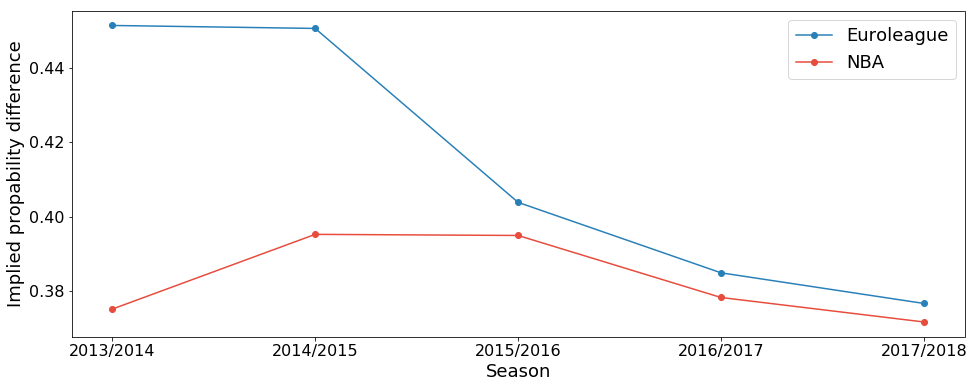

In [12]:
# create separate DataFrames for NBA and Euroleague
df_euro = df[df.League == 'EURO']
df_nba = df[df.League == 'NBA']
# get mean difference between propabilities
diff_euro = df_euro.groupby(['Season'])['Diff_prop'].mean()
diff_nba = df_nba.groupby(['Season'])['Diff_prop'].mean()
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(diff_euro.index, diff_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(diff_euro.index, diff_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
plt.yticks([0.38, 0.4, 0.42, 0.44])
plt.ylabel("Implied propability difference", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("images/implied_prop.png", dpi=200, format="png")

### How common are over times

In [13]:
# Total points
df.groupby(["League", "Season"])["OT"].mean()

League  Season   
EURO    2013/2014    0.063333
        2014/2015    0.033333
        2015/2016    0.072000
        2016/2017    0.050000
        2017/2018    0.060000
NBA     2013/2014    0.062155
        2014/2015    0.063448
        2015/2016    0.062069
        2016/2017    0.055862
        2017/2018    0.048571
Name: OT, dtype: float64

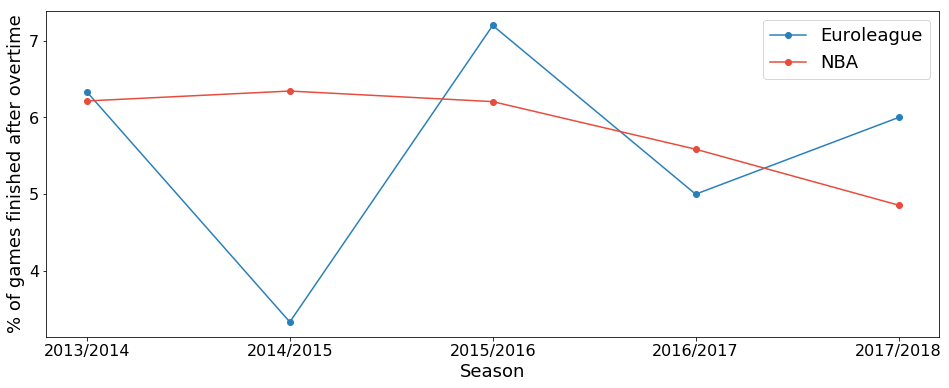

In [15]:
# get season names
seasons = df_euro.Season.unique()[::-1]
# get mean difference between propabilities
ot_euro = df_euro.groupby(['Season'])['OT'].mean() * 100
ot_nba = df_nba.groupby(['Season'])['OT'].mean() * 100
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(ot_euro.index, ot_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(ot_nba.index, ot_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
plt.yticks([4, 5, 6, 7])
plt.ylabel("% of games finished after overtime", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("images/ot_games.png", dpi=200, format="png")

## Total scored points per game

In [16]:
# Total points
df['Total'] = df["Away_score"] + df["Home_score"]
df.groupby(["League", "Season"])["Total"].mean()

League  Season   
EURO    2013/2014    152.043333
        2014/2015    155.626667
        2015/2016    156.756000
        2016/2017    155.956667
        2017/2018    162.836667
NBA     2013/2014    201.364641
        2014/2015    200.064138
        2015/2016    204.708966
        2016/2017    211.124828
        2017/2018    212.219286
Name: Total, dtype: float64

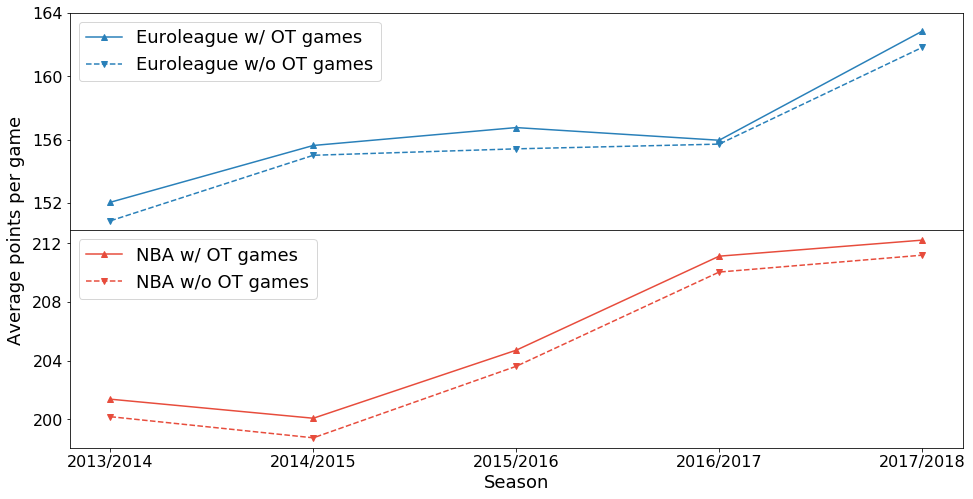

In [18]:
# update NBA and Euroleague DataFrames
df_euro = df[df.League == 'EURO']
df_nba = df[df.League == 'NBA']
# total scored points including games finished with overtime
total_euro = df_euro.groupby(['Season'])['Total'].mean()
total_nba = df_nba.groupby(['Season'])['Total'].mean()
# total scored points excluding games finished with overtime
total_ot_euro = df_euro[df_euro.OT!=1].groupby(['Season'])['Total'].mean()
total_ot_nba = df_nba[df_nba.OT!=1].groupby(['Season'])['Total'].mean()
# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(total_euro.index, total_euro.values, "^-", color="#2980b9", label="Euroleague w/ OT games")
ax1.plot(total_ot_euro.index, total_ot_euro.values, "v--", color="#2980b9", label="Euroleague w/o OT games")
ax1.legend(fontsize=18)
ax1.set_yticks([152, 156, 160, 164])
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(total_nba.index, total_nba.values, "^-", color="#e74c3c", label="NBA w/ OT games")
ax2.plot(total_ot_nba.index, total_ot_nba.values, "v--", color="#e74c3c", label="NBA w/o OT games")
ax2.legend(fontsize=18)
ax2.set_yticks([200, 204, 208, 212])
ax2.set_xlabel("Season", fontsize=18)
ax2.set_ylabel("Average points per game", fontsize=18)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
plt.savefig("images/total_points.png", dpi=200, format="png")

## Home court advantage

In [19]:
df.groupby(["League", "Season"])["Win"].mean()

League  Season   
EURO    2013/2014    0.643333
        2014/2015    0.633333
        2015/2016    0.720000
        2016/2017    0.606667
        2017/2018    0.623333
NBA     2013/2014    0.582873
        2014/2015    0.573103
        2015/2016    0.597931
        2016/2017    0.579310
        2017/2018    0.587857
Name: Win, dtype: float64

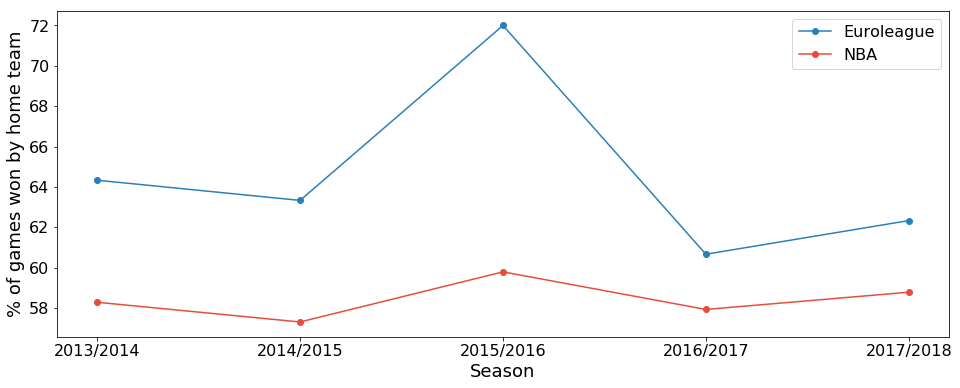

In [21]:
# home team wins
home_w_euro = df_euro.groupby(['Season'])['Win'].mean() * 100
home_w_nba = df_nba.groupby(['Season'])['Win'].mean() * 100
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(home_w_euro.index, home_w_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(home_w_euro.index, home_w_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
plt.ylabel("% of games won by home team", fontsize=18)
plt.legend(fontsize=16)
plt.savefig("images/home_victories.png", dpi=200, format="png")

## Profitable strategies

In [ ]:
# create new columns indicating whatever home or away team won
df_win = pd.concat([df, pd.get_dummies(df['Win']).rename(columns={0.0:"Away_win", 1.0:"Home_win"})], axis=1)
df_win.head()

### 1. bet only on home team or on away team

In [ ]:
df_win["All_home"] = (df_win.Home_p-1)*df_win.Home_win - df_win.Away_win
df_win.groupby(["League", "Season"])["All_home"].sum() / df_win.groupby(["League", "Season"])["All_home"].count()

In [ ]:
df_win["All_away"] = (df_win.Away_p-1)*df_win.Away_win - df_win.Home_win
df_win.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# calculate win precentage of bet only home or only away
df_win_euro = df_win[df_win.League == "EURO"].copy()
df_win_euro_h = df_win_euro.groupby(['Season'])["All_home"].sum() / df_win_euro.groupby(['Season'])["All_home"].count()
df_win_euro_a = df_win_euro.groupby(['Season'])["All_away"].sum() / df_win_euro.groupby(['Season'])["All_away"].count()
df_win_nba = df_win[df_win.League == "NBA"].copy()
df_win_nba_h = df_win_nba.groupby(['Season'])["All_home"].sum() / df_win_nba.groupby(['Season'])["All_home"].count()
df_win_nba_a = df_win_nba.groupby(['Season'])["All_away"].sum() / df_win_nba.groupby(['Season'])["All_away"].count()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(seasons, df_win_euro_h*100, "^-", color="#2980b9", label="Euroleague (bet only home)")
ax1.plot(seasons, df_win_euro_a*100, "v--", color="#2980b9", label="Euroleague (bet only away)")
ax1.legend(fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(seasons, df_win_nba_h*100, "^-", color="#e74c3c", label="NBA (bet only home)")
ax2.plot(seasons, df_win_nba_a*100, "v--", color="#e74c3c", label="NBA (bet only away)")
ax2.legend(fontsize=16)
ax2.set_xlabel("Season", fontsize=18)
ax2.set_ylabel("ROI (%)", fontsize=18)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
plt.savefig("bet_strat_1.png", dpi=200, format="png")

### 2. bet only on home favourite or home long shot

In [ ]:
# take rows where home coefficient is lower than away teams
df_win_home_fav = df_win[df_win.Home_p < df_win.Away_p]
df_win_home_fav.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# take rows where home coefficient is larger than 3.0
df_win_home_long = df_win[df_win.Home_p > 3.0]
df_win_home_long.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# calculate win precentage of betting only on home favourite
df_win_euro_f = df_win_home_fav[df_win_home_fav.League == "EURO"].copy()
df_win_euro_h_f = df_win_euro_f.groupby(['Season'])["All_home"].sum() / df_win_euro_f.groupby(['Season'])["All_home"].count()
df_win_euro_l = df_win_home_long[df_win_home_long.League == "EURO"].copy()
df_win_euro_h_l = df_win_euro_l.groupby(['Season'])["All_home"].sum() / df_win_euro_l.groupby(['Season'])["All_home"].count()
# df_win_euro_a = df_win_euro.groupby(['Season'])["All_away"].sum() / df_win_euro.groupby(['Season'])["All_away"].count()
df_win_nba_f = df_win_home_fav[df_win_home_fav.League == "NBA"].copy()
df_win_nba_h_f = df_win_nba_f.groupby(['Season'])["All_home"].sum() / df_win_nba_f.groupby(['Season'])["All_home"].count()
df_win_nba_l = df_win_home_long[df_win_home_long.League == "NBA"].copy()
df_win_nba_h_l = df_win_nba_l.groupby(['Season'])["All_home"].sum() / df_win_nba_l.groupby(['Season'])["All_home"].count()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(seasons, df_win_euro_h_f*100, "^-", color="#2980b9", label="Euroleague (home favourite)")
ax1.plot(seasons, df_win_euro_h_l*100, "v--", color="#2980b9", label="Euroleague (home long shot)")
ax1.legend(fontsize=16, loc=2)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(seasons, df_win_nba_h_f*100, "^-", color="#e74c3c", label="NBA (home favourite)")
ax2.plot(seasons, df_win_nba_h_l*100, "v--", color="#e74c3c", label="NBA (home long shot)")
ax2.legend(fontsize=16)
ax2.set_xlabel("Season", fontsize=16)
ax2.set_ylabel("ROI (%)", fontsize=16)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
plt.savefig("bet_strat_2.png", dpi=200, format="png")